# ES score analysis of datasets generated **before** run_lv_fix

In [2]:
# packages

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [3]:
# get calculated scores for linear regression, and its regularized versions (with cross-validation), for geometric averaging

geom_lr_scores = pd.read_csv("mtist_datasets/output_geom/inference_result_infer_from_did_geom_mean/es_scores.csv", index_col=0)
geom_lasso_scores = pd.read_csv("mtist_datasets/output_geom/inference_result_infer_from_did_lasso_cv_geom_mean/es_scores.csv", index_col=0)
geom_ridge_scores = pd.read_csv("mtist_datasets/output_geom/inference_result_infer_from_did_ridge_cv_geom_mean/es_scores.csv", index_col=0)
geom_elasticnet_scores = pd.read_csv("mtist_datasets/output_geom/inference_result_infer_from_did_elasticnet_cv_geom_mean/es_scores.csv", index_col=0)

In [4]:
# get number of species of each dataset and add it to score dataframes

n_sp = []
for i in range(len(geom_lr_scores)):
    n_sp.append(open(f"mtist_datasets/dataset_{i}.csv", "r").readlines()[0].count("species_"))

geom_lr_scores["n_sp"] = n_sp
geom_lasso_scores["n_sp"] = n_sp
geom_ridge_scores["n_sp"] = n_sp
geom_elasticnet_scores["n_sp"] = n_sp

In [5]:
# create lists of dataframes to simplify calls later

geom_score_dfs = [geom_lr_scores, geom_lasso_scores, geom_ridge_scores, geom_elasticnet_scores]
reg_names = ["Linear Regression", "Lasso", "Ridge", "ElasticNet"]

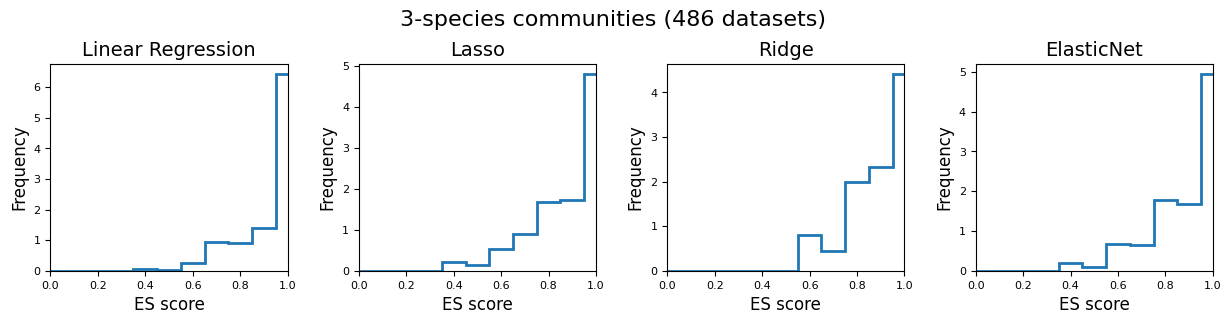

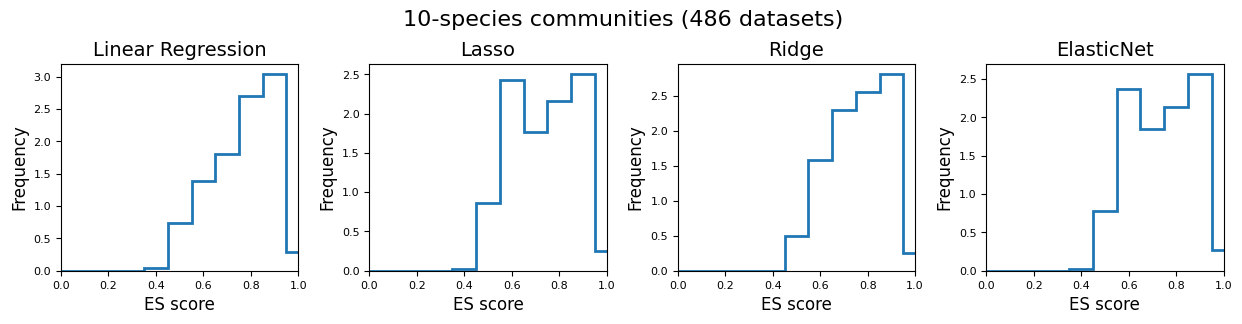

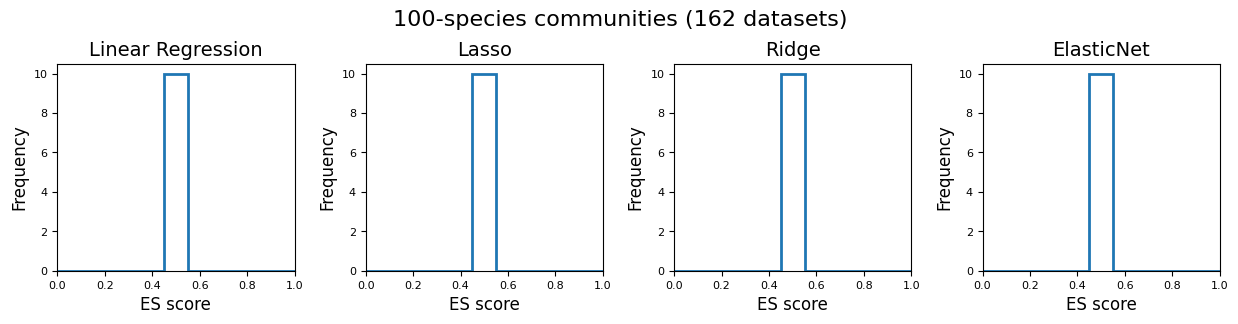

In [9]:
# plotting

bins = np.linspace(-0.05, 1.05, 12)

plt.subplots(1, 4, figsize=(15,3))
for i in range(len(geom_score_dfs)):
    geom_df = geom_score_dfs[i]
    plt.subplot(1, 4, i+1)
    plt.hist(geom_df[geom_df.n_sp==3].raw, bins=bins, histtype="step", lw=2, density=True)
    plt.xlim(0, 1)
    plt.xlabel("ES score", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(reg_names[i], fontsize=14)
    # plt.yscale("log")
plt.suptitle(f"3-species communities ({len(geom_df[geom_df.n_sp==3])} datasets)", fontsize=16)
plt.subplots_adjust(top=0.8, wspace=0.3)
plt.show()

plt.subplots(1, 4, figsize=(15,3))
for i in range(len(geom_score_dfs)):
    geom_df = geom_score_dfs[i]

    plt.subplot(1, 4, i+1)
    plt.hist(geom_df[geom_df.n_sp==10].raw, bins=bins, histtype="step", lw=2, density=True)
    plt.xlim(0, 1)
    plt.xlabel("ES score", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(reg_names[i], fontsize=14)
    # plt.yscale("log")
plt.suptitle(f"10-species communities ({len(geom_df[geom_df.n_sp==10])} datasets)", fontsize=16)
plt.subplots_adjust(top=0.8, wspace=0.3)
plt.show()

plt.subplots(1, 4, figsize=(15,3))
for i in range(len(geom_score_dfs)):
    geom_df = geom_score_dfs[i]
    plt.subplot(1, 4, i+1)
    plt.hist(geom_df[geom_df.n_sp==100].raw, bins=bins, histtype="step", lw=2, density=True)
    plt.xlim(0, 1)
    plt.xlabel("ES score", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(reg_names[i], fontsize=14)
    # plt.yscale("log")
plt.suptitle(f"100-species communities ({len(geom_df[geom_df.n_sp==100])} datasets)", fontsize=16)
plt.subplots_adjust(top=0.8, wspace=0.3)
plt.show()